In [114]:
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils, stamp_correction
from sleeprnn.data.cap_full_ss import ALL_IDS
from sleeprnn.detection import metrics

viz.notebook_full_width()
%matplotlib inline

DATASET_DIR = os.path.abspath(os.path.join(utils.PATH_DATA, 'unlabeled_cap_npz'))

# Loader to read on-demand

In [95]:
def get_id(i):
    return ALL_IDS[i]


class CapFullLoader(object):
    def __init__(self, fs=200, min_ss_duration=0.3, max_ss_duration=3.0, page_duration=20, dataset_dir=DATASET_DIR):
        self.fs = fs
        self.min_ss_duration = min_ss_duration
        self.max_ss_duration = max_ss_duration
        self.page_duration = page_duration
        # Parameters of dataset
        self.original_page_duration = 30
        self.n2_id = 'S2'
        self.dataset_dir = dataset_dir
        
    def read_subject_data(self, subject_id, keep_only_n2_spindles=False):
        file_npz, file_spindle_1, file_spindle_2 = self.get_file_paths(subject_id)
        signal, hypnogram_original, meta = self.read_npz(file_npz)
        n2_pages = self.get_n2_pages(hypnogram_original)
        all_pages = self.get_all_pages(signal.size)
        marks_1 = self.read_marks(file_spindle_1)
        marks_2 = self.read_marks(file_spindle_2)
        # n2 filtering in 20s pages
        page_size = int(self.fs * self.page_duration)
        marks_1_n2 = utils.extract_pages_for_stamps(marks_1, n2_pages, page_size)
        marks_2_n2 = utils.extract_pages_for_stamps(marks_2, n2_pages, page_size)
        
        subject_data_dict = {
            'signal': signal,
            'hypnogram_original': hypnogram_original,
            'n2_pages': n2_pages,
            'wn_pages': all_pages,
            'spindle1_all': marks_1,
            'spindle2_all': marks_2,
            'spindle1_n2': marks_1_n2,
            'spindle2_n2': marks_2_n2,
            'metadata': meta
        }
        return subject_data_dict
    
    def get_file_paths(self, subject_id):
        file_npz = os.path.join(self.dataset_dir, 'register_and_state', "cap_%s.npz" % subject_id)
        file_spindle_1 = os.path.join(
            self.dataset_dir, 'spindle',
            'spindle_1',
            'EventDetection_s%s_absSigPow(1.75)_relSigPow(1.6)_sigCov(1.8)_sigCorr(0.75).txt' % subject_id)
        file_spindle_2 = os.path.join(
            self.dataset_dir, 'spindle',
            'spindle_2',
            'EventDetection_s%s_absSigPow(1.25)_relSigPow(1.6)_sigCov(1.3)_sigCorr(0.69).txt' % subject_id)
        return file_npz, file_spindle_1, file_spindle_2
    
    def read_npz(self, file_path):
        data = np.load(file_path)
        hypnogram = data['hypnogram']
        signal = data['signal']
        # Signal is already filtered to 0.1-35 and sampled to 200Hz
        original_fs = data['sampling_rate']
        # Now resample to the required frequency
        if self.fs != original_fs:
            print('Resampling from %d Hz to required %d Hz' % (original_fs, self.fs))
            signal = utils.resample_signal(signal, fs_old=original_fs, fs_new=self.fs)
        signal = signal.astype(np.float32)
        meta = {}
        for key in data.files:
            if key not in ['signal', 'hypnogram']:
                meta[key] = data[key].item()
        return signal, hypnogram, meta
    
    def get_n2_pages(self, hypnogram_original):
        signal_total_duration = len(hypnogram_original) * self.original_page_duration
        # Extract N2 pages
        n2_pages_original = np.where(hypnogram_original == self.n2_id)[0]
        onsets_original = n2_pages_original * self.original_page_duration
        offsets_original = (n2_pages_original + 1) * self.original_page_duration
        total_pages = int(np.ceil(signal_total_duration / self.page_duration))
        n2_pages_onehot = np.zeros(total_pages, dtype=np.int16)
        for i in range(total_pages):
            onset_new_page = i * self.page_duration
            offset_new_page = (i + 1) * self.page_duration
            for j in range(n2_pages_original.size):
                intersection = (onset_new_page < offsets_original[j]) and (onsets_original[j] < offset_new_page)
                if intersection:
                    n2_pages_onehot[i] = 1
                    break
        n2_pages = np.where(n2_pages_onehot == 1)[0]
        # Drop first, last and second to last page of the whole registers
        # if they where selected.
        last_page = total_pages - 1
        n2_pages = n2_pages[
            (n2_pages != 0)
            & (n2_pages != last_page)
            & (n2_pages != last_page - 1)]
        n2_pages = n2_pages.astype(np.int16)
        return n2_pages
    
    def get_all_pages(self, signal_length):
        total_pages = int(np.ceil(signal_length / (self.fs * self.page_duration)))
        all_pages = np.arange(1, total_pages - 2, dtype=np.int16)
        return all_pages
    
    def read_marks(self, file_path):
        pred_data = pd.read_csv(file_path, sep='\t')
        # We substract 1 to translate from matlab to numpy indexing system
        start_samples = pred_data.start_sample.values - 1
        end_samples = pred_data.end_sample.values - 1
        marks = np.stack([start_samples, end_samples], axis=1).astype(np.int32)
        # Sample-stamps assume 200Hz sampling rate
        if self.fs != 200:
            print('Correcting marks from 200 Hz to %d Hz' % self.fs)
            # We need to transform the marks to the new sampling rate
            marks_time = marks.astype(np.float32) / 200.0
            # Transform to sample-stamps
            marks = np.round(marks_time * self.fs).astype(np.int32)
        # Combine marks that are too close according to standards
        marks = stamp_correction.combine_close_stamps(marks, self.fs, self.min_ss_duration)
        # Fix durations that are outside standards
        marks = stamp_correction.filter_duration_stamps(marks, self.fs, self.min_ss_duration, self.max_ss_duration)
        return marks

In [96]:
loader = CapFullLoader()

# Check single subject

In [111]:
subject_id = get_id(6)
print("Subject id %s" % subject_id)
data = loader.read_subject_data(subject_id, keep_only_n2_spindles=False)
print("Available keys:", list(data.keys()))

print("")
for key in data.keys():
    if 'metadata' not in key:
        print(key, data[key].shape, data[key].dtype)
print("Metadata:")
pprint(data['metadata'])

print("")
spindle1_n2_original = utils.extract_pages_for_stamps(
    data['spindle1_all'], 
    np.where(data['hypnogram_original'] == loader.n2_id)[0], 
    int(loader.original_page_duration * loader.fs)
)
print("spindle 1 in N2 original:", spindle1_n2_original.shape)

spindle2_n2_original = utils.extract_pages_for_stamps(
    data['spindle2_all'], 
    np.where(data['hypnogram_original'] == loader.n2_id)[0], 
    int(loader.original_page_duration * loader.fs)
)
print("spindle 2 in N2 original:", spindle2_n2_original.shape)

Subject id 1-007
Available keys: ['signal', 'hypnogram_original', 'n2_pages', 'wn_pages', 'spindle1_all', 'spindle2_all', 'spindle1_n2', 'spindle2_n2', 'metadata']

signal (5908000,) float32
hypnogram_original (985,) <U2
n2_pages (615,) int16
wn_pages (1474,) int16
spindle1_all (607, 2) int32
spindle2_all (1210, 2) int32
spindle1_n2 (549, 2) int32
spindle2_n2 (999, 2) int32
Metadata:
{'bandpass_filter': 'scipy.signal.butter, 0.1-35Hz, order 3',
 'channel': 'C3-A2',
 'dataset_id': 'CAP Sleep Database',
 'original_sampling_rate': 128,
 'resampling_function': 'scipy.signal.resample_poly',
 'sampling_rate': 200,
 'scoring_epoch_duration_seconds': 30,
 'signal_physical_units': 'microvolts',
 'start_time_hh_mm_ss': '22:21:11',
 'subject_id': '1-007'}

spindle 1 in N2 original: (546, 2)
spindle 2 in N2 original: (994, 2)


### General Statistics

In [107]:
print("Subject %s" % subject_id)

print("Signal total duration: %1.2f [s] (%1.2f [h])" % (
    data['signal'].size / loader.fs,
    data['signal'].size / loader.fs / 3600,
))
print("Total REM sleep (original): %1.2f [h]" % (
    np.sum(
        data['hypnogram_original'] == 'R'
    ) * loader.original_page_duration / 3600
))
print("Total NREM sleep (original): %1.2f [h]" % (
    np.sum(
        (data['hypnogram_original'] == 'S1')
        | (data['hypnogram_original'] == 'S2')
        | (data['hypnogram_original'] == 'S3')
        | (data['hypnogram_original'] == 'S4')
    ) * loader.original_page_duration / 3600
))
print("Total N2 sleep (original): %1.2f [h]" % (
    np.sum(
        (data['hypnogram_original'] == 'S2')
    ) * loader.original_page_duration / 3600
))
print("Fraction N2 / Sleep (original): %1.2f %%" % (
    100 * np.sum(data['hypnogram_original'] == 'S2') / np.sum(
        (data['hypnogram_original'] == 'S1')
        | (data['hypnogram_original'] == 'S2')
        | (data['hypnogram_original'] == 'S3')
        | (data['hypnogram_original'] == 'S4')
        | (data['hypnogram_original'] == 'R')
    )
))
print("N spindle 1 in N2: %d" % data['spindle1_n2'].shape[0])
print("N spindle 2 in N2: %d" % data['spindle2_n2'].shape[0])
duration_1 = (data['spindle1_n2'][:, 1] - data['spindle1_n2'][:, 0] + 1) / loader.fs
duration_2 = (data['spindle2_n2'][:, 1] - data['spindle2_n2'][:, 0] + 1) / loader.fs
print("Min-Mean-Max duration spindle 1 in N2: %1.6fs - %1.6fs - %1.6fs" % (
    np.min(duration_1), np.mean(duration_1), np.max(duration_1)
))
print("Min-Mean-Max duration spindle 2 in N2: %1.6fs - %1.6fs - %1.6fs" % (
    np.min(duration_2), np.mean(duration_2), np.max(duration_2)
))
print("Density of spindle 1 (in N2 original): %1.4f spm" % (
    spindle1_n2_original.shape[0] / (
        np.sum((data['hypnogram_original'] == 'S2')) * loader.original_page_duration / 60
    )
))
print("Density of spindle 2 (in N2 original): %1.4f spm" % (
    spindle2_n2_original.shape[0] / (
        np.sum((data['hypnogram_original'] == 'S2')) * loader.original_page_duration / 60
    )
))

print("Range of signal min-mean-max and std: %1.4f, %1.4f, %1.4f, %1.4f" % (
    data['signal'].min(),
    data['signal'].mean(),
    data['signal'].max(),
    data['signal'].std(),
))

Subject 1-007
Signal total duration: 29540.00 [s] (8.21 [h])
Total REM sleep (original): 2.06 [h]
Total NREM sleep (original): 5.52 [h]
Total N2 sleep (original): 3.37 [h]
Fraction N2 / Sleep (original): 44.44 %
N spindle 1 in N2: 549
N spindle 2 in N2: 999
Min-Mean-Max duration spindle 1 in N2: 0.300000s - 0.739162s - 3.000000s
Min-Mean-Max duration spindle 2 in N2: 0.300000s - 0.983784s - 3.000000s
Density of spindle 1 (in N2 original): 2.7030 spm
Density of spindle 2 (in N2 original): 4.9208 spm
Range of signal min-mean-max and std: -317.0630, 0.0000, 341.9946, 29.3830


### N2 spectrum

Segmented signal (615, 4000)


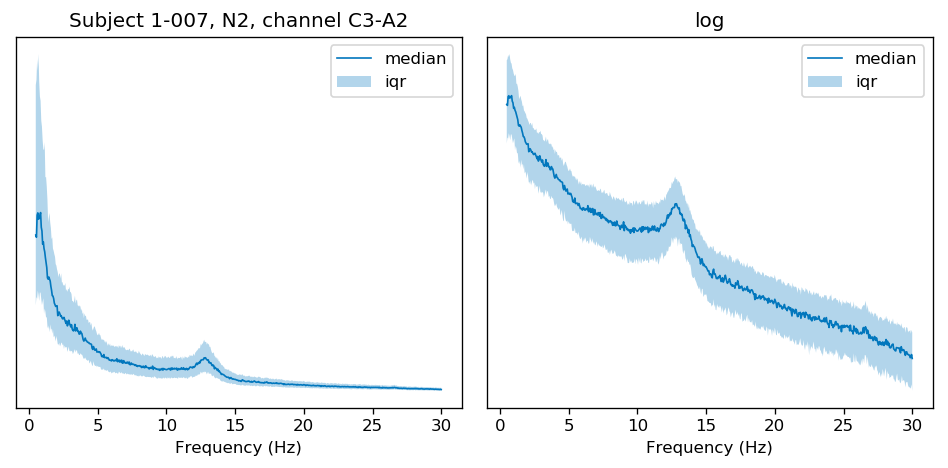

In [112]:
# spectrum
segmented_signal = utils.extract_pages(data['signal'], data['n2_pages'], int(loader.fs * loader.page_duration))
print("Segmented signal", segmented_signal.shape)
all_pages_power = []
for page_signal in segmented_signal:
    power, freq = utils.power_spectrum(page_signal, loader.fs)
    all_pages_power.append(power)

pages_power = np.stack(all_pages_power, axis=0)
min_freq = 0.5
max_freq = 30
plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
plot_pages_power = pages_power[:, plot_indices]
plot_freq = freq[plot_indices]
plot_power_min = np.min(plot_pages_power, axis=0)
plot_power_max = np.min(plot_pages_power, axis=0)
plot_power_mean = np.mean(plot_pages_power, axis=0)
plot_power_25, plot_power_50, plot_power_75 = np.percentile(plot_pages_power, (25, 50, 75), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=120)

ax = axes[0]
ax.plot(plot_freq, plot_power_50, color=viz.PALETTE['blue'], linewidth=1, label='median')
ax.fill_between(plot_freq, plot_power_25, plot_power_75, facecolor=viz.PALETTE['blue'], alpha=0.3, label='iqr')
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title('Subject %s, N2, channel %s' % (subject_id, data['metadata']['channel']))

ax = axes[1]
ax.plot(plot_freq, np.log10(plot_power_50), color=viz.PALETTE['blue'], linewidth=1, label='median')
ax.fill_between(plot_freq, np.log10(plot_power_25), np.log10(plot_power_75), facecolor=viz.PALETTE['blue'], alpha=0.3, label='iqr')
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title('log')

plt.tight_layout()
plt.show()

### Segment visualization

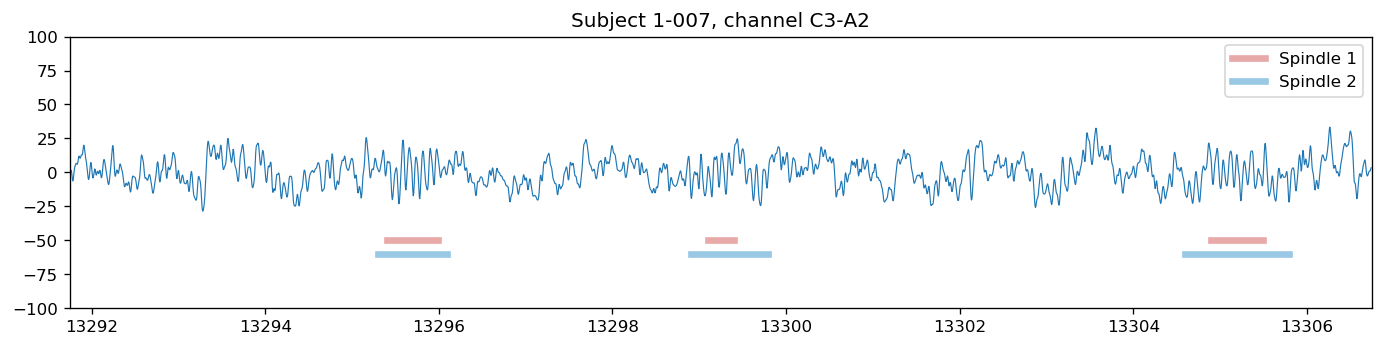

In [104]:
center_loc = np.random.RandomState(seed=0).choice(data['spindle1_n2'].mean(axis=1).astype(np.int32))
window_size = 15
start_sample = int(center_loc - window_size * loader.fs // 2)
end_sample = int(start_sample + window_size * loader.fs)

time_axis = np.arange(start_sample, end_sample) / loader.fs
fig, ax = plt.subplots(1, 1, figsize=(14, 3), dpi=120)
ax.plot(time_axis, data['signal'][start_sample:end_sample], linewidth=0.7)
ax.set_xlim([start_sample/loader.fs, end_sample/loader.fs])
ax.set_ylim([-100, 100])

spindle1 = utils.filter_stamps(data['spindle1_n2'], start_sample, end_sample)
spindle2 = utils.filter_stamps(data['spindle2_n2'], start_sample, end_sample)
for i, mark in enumerate(spindle1):
    label = 'Spindle 1' if i == 0 else None
    ax.plot(mark / loader.fs, [-50, -50], color=viz.PALETTE['red'], linewidth=4, alpha=0.4, label=label)
for i, mark in enumerate(spindle2):
    label = 'Spindle 2' if i == 0 else None
    ax.plot(mark / loader.fs, [-60, -60], color=viz.PALETTE['blue'], linewidth=4, alpha=0.4, label=label)
ax.set_title("Subject %s, channel %s" % (subject_id, data['metadata']['channel']))
ax.legend(loc='upper right')
plt.show()

### Agreement between spindle1 and spindle2

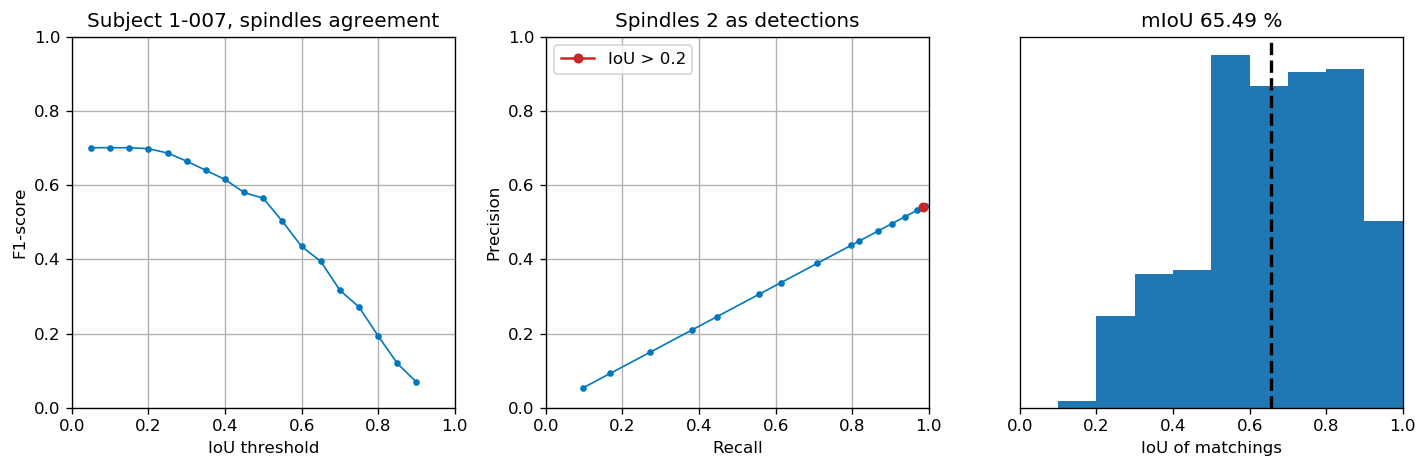

In [152]:
iou_matching, idx_matching = metrics.matching(spindle1_n2_original, spindle2_n2_original)
iou_thr_list = np.linspace(0, 1, 21)[1:-2]
recall_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.RECALL, iou_matching=iou_matching)
precision_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.PRECISION, iou_matching=iou_matching)
f1score_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.F1_SCORE, iou_matching=iou_matching)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=120)

ax = axes[0]
ax.plot(iou_thr_list, f1score_vs_iou, linewidth=1, color=viz.PALETTE['blue'], marker='o', markersize=3)
ax.set_xlim([0, 1])
ax.set_xlabel("IoU threshold")
ax.set_ylabel("F1-score")
ax.set_ylim([0, 1])
ax.grid()
ax.set_title("Subject %s, spindles agreement" % subject_id)

ax = axes[1]
ax.plot(recall_vs_iou, precision_vs_iou, linewidth=1, color=viz.PALETTE['blue'], marker='o', markersize=3)
iou_02_loc = np.argmin((iou_thr_list - 0.2)**2)
ax.plot(recall_vs_iou[iou_02_loc], precision_vs_iou[iou_02_loc], color=viz.PALETTE['red'], marker='o', markersize=5, label="IoU > 0.2")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
ax.set_title("Spindles 2 as detections")
ax.legend(loc="upper left")

ax = axes[2]
iou_of_matchings = iou_matching[idx_matching != -1]
bins = np.linspace(0, 1, 11)
ax.hist(iou_of_matchings, bins=bins)
mean_iou_of_matchings = np.mean(iou_of_matchings)
ax.axvline(mean_iou_of_matchings, color='k', linestyle='--', linewidth=2)
ax.set_xlim([0, 1])
ax.set_ylim([0, None])
ax.set_title("mIoU %1.2f %%" % (100 * mean_iou_of_matchings))
ax.set_xlabel("IoU of matchings")
ax.set_yticks([])

plt.tight_layout()
plt.show()

# CAP subject's N2 mean spectrum

In [153]:
spectrum_dict = {}
min_freq = 0.5
max_freq = 30
for subject_id in ALL_IDS:
    data = loader.read_subject_data(subject_id, keep_only_n2_spindles=False)
    # spectrum
    segmented_signal = utils.extract_pages(data['signal'], data['n2_pages'], int(loader.fs * loader.page_duration))
    all_pages_power = []
    for page_signal in segmented_signal:
        power, freq = utils.power_spectrum(page_signal, loader.fs)
        all_pages_power.append(power)
    pages_power = np.stack(all_pages_power, axis=0)
    plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
    plot_pages_power = pages_power[:, plot_indices]
    plot_freq = freq[plot_indices]
    plot_power_mean = np.mean(plot_pages_power, axis=0)
    spectrum_dict[subject_id] = np.stack([plot_freq, plot_power_mean], axis=1)

Segmented signal (776, 4000)
Segmented signal (562, 4000)
Segmented signal (530, 4000)
Segmented signal (611, 4000)
Segmented signal (635, 4000)
Segmented signal (744, 4000)
Segmented signal (615, 4000)
Segmented signal (612, 4000)
Segmented signal (714, 4000)
Segmented signal (400, 4000)
Segmented signal (405, 4000)
Segmented signal (641, 4000)
Segmented signal (643, 4000)
Segmented signal (543, 4000)
Segmented signal (763, 4000)
Segmented signal (687, 4000)
Segmented signal (225, 4000)
Segmented signal (459, 4000)
Segmented signal (739, 4000)
Segmented signal (690, 4000)
Segmented signal (298, 4000)
Segmented signal (526, 4000)
Segmented signal (651, 4000)
Segmented signal (347, 4000)
Segmented signal (770, 4000)
Segmented signal (413, 4000)
Segmented signal (329, 4000)
Segmented signal (443, 4000)
Segmented signal (910, 4000)
Segmented signal (460, 4000)
Segmented signal (513, 4000)
Segmented signal (226, 4000)
Segmented signal (643, 4000)
Segmented signal (646, 4000)
Segmented sign

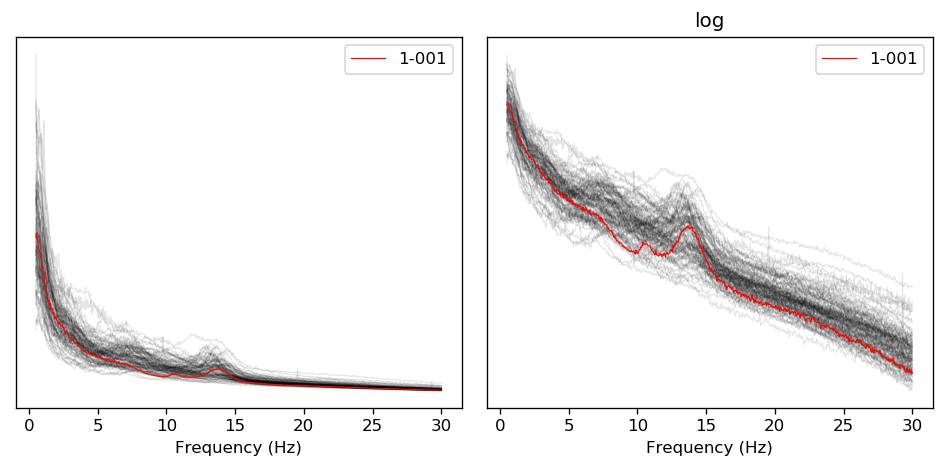

In [157]:
emph_subject = [get_id(0)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=120)

ax = axes[0]
for subject_id in ALL_IDS:
    if subject_id in emph_subject:
        ax.plot(spectrum_dict[subject_id][:, 0], spectrum_dict[subject_id][:, 1], linewidth=0.7, color="r", alpha=1, zorder=20, label=subject_id)
    else:
        ax.plot(spectrum_dict[subject_id][:, 0], spectrum_dict[subject_id][:, 1], linewidth=0.7, color="k", alpha=0.1)
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax = axes[1]
for subject_id in ALL_IDS:
    if subject_id in emph_subject:
        ax.plot(spectrum_dict[subject_id][:, 0], np.log10(spectrum_dict[subject_id][:, 1]), linewidth=0.7, color="r", alpha=1, zorder=20, label=subject_id)
    else:
        ax.plot(spectrum_dict[subject_id][:, 0], np.log10(spectrum_dict[subject_id][:, 1]), linewidth=0.7, color="k", alpha=0.1)
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title('log')

plt.tight_layout()
plt.show()

# Check whole dataset statistics

In [ ]:
"""
The idea is to elaborate a Table with the following columns (all containing scalars):

suject_id
channel
age
sex
pathology

# Signal descriptors:
signal_duration_hours
signal_min
signal_mean
signal_std
signal_max
# fft -> use original 20s n2 pages here
mean_power_n2_mean_delta_slow
mean_power_n2_mean_delta_fast
mean_power_n2_mean_theta
mean_power_n2_mean_alpha
mean_power_n2_mean_sigma
mean_power_n2_mean_beta

# original hypnogram descriptors:
sleep_duration_hours
rem_duration_hours
n1_duration_hours
n2_duration_hours
n3_duration_hours
n4_duration_hours
n2_to_sleep_ratio
flag_contain_invalid_labels: 1 if there are labels different from ?, W, R, S1, S2, S3, S4.

# Spindles descriptors: -> use original n2 pages here
spindlesX_n2_number where X in {1, 2}
spindlesX_n2_density  
spindlesX_n2_mean_duration
spindle_1_to_2_recall_at_iou0.2
spindle_1_to_2_precision_at_iou0.2
spindle_1_to_2_f1score_at_iou0.2
spindle_1_to_2_mean_nonzero_iou
 
# Spindle + signal descriptors: -> use original n2 pages here
spindlesX_n2_mean_frequency
spindlesX_n2_mean_amplitude
spindlesX_n2_mean_power_ratio

"""